# Vorhersage des Ödometerversuches implementiert mit PINA
Ziel war die Implementierung eines neuronalen Netzwerks zur Modellierung des Ödometerversuchs. Dabei wurden gegebene Input-Parameter verarbeitet, um Output-Parameter vorherzusagen. Die physikalischen Rahmenbedingungen wurden zunächst auf Null gesetzt, sodass das Modell ausschließlich auf der KI-basierten Struktur arbeitet, ohne physikalische Optimierungen durch Physical Informed Neural Networks (PINNs).
<br>
Diese grundlegende Umsetzung bildet die Basis für weiterführende Optimierungen, wie die Integration physikalischer Gesetzmäßigkeiten, die jedoch nicht Teil des initialen Arbeitsauftrags waren.

### Was ist PINA?
PINA ist eine Open-Source-Python-Bibliothek, die eine intuitive Schnittstelle zur Lösung von Differentialgleichungen bietet, indem sie Physik-informierte Neuronale Netze (PINNs), Neuronale Operatoren (NOs) oder eine Kombination aus beiden verwendet. Basierend auf PyTorch und PyTorch Lightning ermöglicht PINA die formale Darstellung spezifischer (differentieller) Probleme und deren Lösung mittels neuronaler Netze.<br><br>
<strong>Hauptmerkmale von PINA:</strong>

- <span style="color:gray;"><i>Problemformulierung: Ermöglicht die Übersetzung mathematischer Gleichungen in Python-Code, um das Differentialproblem zu definieren.</i></span>
    - <small><i>→ In diesem Arbeitsauftrag nicht notwendig, da das neuronale Netzwerk ohne physikalische Gesetzmäßigkeiten trainiert wurde.</i></small>
- Modelltraining: Bietet Werkzeuge zum Training neuronaler Netze zur Lösung des definierten Problems.
- Lösungsauswertung: Erlaubt die Visualisierung und Analyse der approximierten Lösungen.

<small><i>Hinweis: Die physikalische Modellierung und die Einbindung von Differentialgleichungen zur Optimierung des Netzwerks (z. B. mittels PINNs) war nicht Teil dieses Arbeitsauftrags, könnte aber in einem späteren Schritt ergänzt werden.</i></small>
## Grundlagen
In diesem Notebook wird der Ödometerversuch <strong>ohne</strong> Randbedingungen betrachtet. Es werden vorberechnetet Daten aus der Exceltabelle `files/oedometer/oedo_trainingsdata.xlsx` verwendet.<br>
#### Das Problem ist wie folgt definiert:
$$
\begin{array}{rcl}
    \sigma_{t+1} & = & \sigma_{t}+\Delta\sigma \\ \\
    \Delta\sigma & = & E_s\cdot \Delta\epsilon \\ 
    E_s & = & \frac{1+e_0}{C_c} \cdot \sigma_t
\end{array}
\hspace{2cm}
\begin{array}{l}
    \textbf{Annahmen:} \\ \\
    \text{Startwert d. Iteration: } \sigma_t = 1,00 \\ 
    e_0 = 1,00 \\ 
    C_c = 0,005 \\
    \Delta\epsilon = 0,0005
\end{array}
$$
<div = style="text-align: center;">
    <img alt="Problem Oedometer Preview" src="./graph/problem_preview.png" width="50%" height=auto>
</div>

<br> 

Um das PINA-Model zu testen werden wir folgende vorberechnete Werte verwenden: `Input` { $\sigma_t$ ; $\Delta\epsilon$ }, `Output` { $\sigma_{t+1}$ }.
<br>
### Variablendeklaration
- $\sigma_t$ = `sigma_t`
- $\Delta\epsilon$ = `delta_epsilon`
- $\sigma_{t+1}$ = `delta_sigma`
## Einstellungen und Utilities

In [1]:
from IPython.display import display, Markdown
import matplotlib  # Keine doppelte Darstellung des Plots
import matplotlib.pyplot as plt
import torch
import numpy as np

# Debugger: Aktiviert
debug_mode = True
# Normalisierung der Daten: Deaktiviert
normalize_data = False
use_excel = False

input_data = 'sigma_t'
output_data = 'e_s'

# Trainingsdaten e_0:float=1.00, C_c:float=0.005, delta_epsilon:float=0.0005, sigma_t:float=1.00, max_n:int=50
oedo_parameter = {'e_0':1.00, 'C_c':0.005, 'delta_epsilon':0.0005, 'sigma_t':1.00, 'max_n':100, 'rand_epsilon':False}

graph_folder = 'graph'
img_extensions = '.png'

img_visual_loss = 'visual_loss'
img_nn_result_error = 'img_nn_result_error'
img_visual_prediction_vs_truesolution_comp = 'visual_prediction-vs-truesolution_comp'
img_visual_prediction_vs_truesolution_comp0 = 'visual_prediction-vs-truesolution_comp0'
img_visual_prediction_vs_truesolution_comp1 = 'visual_prediction-vs-truesolution_comp1'
img_visual_prediction_vs_truesolution_comp2 = 'visual_prediction-vs-truesolution_comp2'
img_visual_prediction_vs_truesolution = 'visual_prediction-vs-truesolution'
img_visual_sampling = 'visual_sampling'

def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.
    
    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """
    
    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"
    
    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.
    
    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.
    
    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """
    
    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred.flatten())  # Falls `delta_sigma_pred` ein 2D-Array ist
    
    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]), 
        "delta_epsilon" : list(delta_epsilon[:min_len]), 
        "sigma_t" : list(sigma_t[:min_len]), 
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }
    
    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

def plot_prediction_vs_true_solution(pinn, data_dict, graph_folder, img_visual_prediction_vs_truesolution, 
                                     img_extensions, y_axis='delta_sigma', max_i=20, plot_type="line"):
    """
    Erstellt und speichert eine Vorhersage- vs. True-Solution-Grafik für ein gegebenes PINN-Modell.

    :param pinn: Das trainierte PINN-Modell zur Vorhersage von delta_sigma
    :param data_dict: Dictionary mit den Eingabe- und wahren Ausgabe-Daten
    :param graph_folder: Ordner, in dem das Bild gespeichert wird
    :param img_visual_prediction_vs_truesolution: Dateiname der gespeicherten Grafik (ohne Erweiterung)
    :param img_extensions: Dateiformat der gespeicherten Grafik (z.B. '.png' oder '.jpg')
    :param max_i: Anzahl der Datenpunkte, die im Plot gezeigt werden sollen (Default: 20)
    :param delta_epsilon: Wert für delta_epsilon, um ihn im Titel anzuzeigen (optional)
    :param plot_type: Art der Darstellung - "line" für Linienplot, "scatter" für Punktplot (Default: "line")
    """

    # Überprüfen, ob die notwendigen Keys vorhanden sind
    if "sigma_t" not in data_dict or y_axis not in data_dict:
        print(f"Fehler: sigma_t oder y_axis fehlen im data_dict!")
        return

    # Eingabedaten für das Modell vorbereiten
    input_data = LabelTensor(torch.tensor(
        np.column_stack((data_dict['sigma_t'], data_dict['delta_epsilon'])), 
        dtype=torch.float), ['sigma_t', 'delta_epsilon'])

    # Vorhersage berechnen
    sigma_t_pred = pinn(input_data).detach().numpy()
    
    # Plot erstellen
    plt.figure(figsize=(10, 5))

    y_vals = data_dict[y_axis][0:max_i]
    x_true = data_dict['delta_sigma'][0:max_i]
    x_pred = sigma_t_pred[0:max_i]

    if plot_type == "line":
        plt.plot(x_true, y_vals, label="True Solution (delta_sigma)", linestyle='dashed', color='blue')
        plt.plot(x_pred, y_vals, label="NN Prediction (delta_sigma)", linestyle='solid', color='red')
    elif plot_type == "scatter":
        plt.scatter(x_true, y_vals, label="True Solution (delta_sigma)", color='blue', marker='o')
        plt.scatter(x_pred, y_vals, label="NN Prediction (delta_sigma)", color='red', marker='x')

    plt.xlabel("delta_sigma")
    plt.ylabel(y_axis)
    plt.title(f"Prediction vs. True Solution (max_i={max_i-1})")
    plt.legend()
    plt.grid()
    plt.gca().invert_yaxis()
    
    # Bild speichern
    img_path = f'./{graph_folder}/{img_visual_prediction_vs_truesolution}{img_extensions}'
    plt.savefig(img_path)
    plt.close()  # Verhindert doppelte Darstellung

    # Markdown-Ausgabe in Jupyter Notebook
    display(Markdown(f'![Prediction vs True Solution]({img_path})<br>**Hinweis:** Datenpunkte liegen sehr nahe beieinander.'))


## Laden der Daten aus `oedo_trainingsdata.xlsx`

In [2]:
import pandas as pd
import numpy as np
from sympy.integrals.heurisch import components

def extract_excel(file_path, sheet_name, selected_columns, row_start_range):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Dynamische Ermittlung der letzten Zeile mit Daten
    row_start_range = 0  # Startet bei Zeile 6 (0-basiert)
    row_end_range = df.dropna(how="all").last_valid_index() + 1  # Letzte Zeile mit Daten
        
    # Daten extrahieren
    data_subset = df.iloc[row_start_range:row_end_range, selected_columns]
    data_dict = {col: np.array(data_subset[col]) for col in data_subset.columns}
    
    if debug_mode:
        print(data_dict)
        dict_to_markdown_table(data=data_dict,title=file_path)
    
    # Daten als dict speichern
    return data_dict
    
if use_excel:
    data_dict = extract_excel(file_path, sheet_name, selected_columns, row_start_range)

## Laden der Daten aus `Python`

In [3]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005, 
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]
        
        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])
        
        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen
    
    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])            
    
    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

if not use_excel:
    data_dict = dict(vars(Oedometer(**oedo_parameter)))
    display(dict_to_markdown_table(data_dict, 'Ödometerdaten'))

### Ödometerdaten

| Index | e_0 | C_c | sigma_t | delta_epsilon | total_epsilon | delta_sigma | e_s |
|--|----|----|--------|--------------|--------------|------------|----|
| 0 | 1.0 | 0.005 | 1.0 | 0.0005 | 0 | 0.2 | 400.0 |
| 1 | 1.0 | 0.005 | 1.2 | 0.0005 | 0.0005 | 0.24 | 480.0 |
| 2 | 1.0 | 0.005 | 1.44 | 0.0005 | 0.001 | 0.288 | 576.0 |
| 3 | 1.0 | 0.005 | 1.728 | 0.0005 | 0.0015 | 0.3456 | 691.2 |
| 4 | 1.0 | 0.005 | 2.0736 | 0.0005 | 0.002 | 0.4147 | 829.44 |
| 5 | 1.0 | 0.005 | 2.4883 | 0.0005 | 0.0025 | 0.4977 | 995.328 |
| 6 | 1.0 | 0.005 | 2.986 | 0.0005 | 0.003 | 0.5972 | 1194.3936 |
| 7 | 1.0 | 0.005 | 3.5832 | 0.0005 | 0.0035 | 0.7166 | 1433.2723 |
| 8 | 1.0 | 0.005 | 4.2998 | 0.0005 | 0.004 | 0.86 | 1719.9268 |
| 9 | 1.0 | 0.005 | 5.1598 | 0.0005 | 0.0045 | 1.032 | 2063.9121 |
| 10 | 1.0 | 0.005 | 6.1917 | 0.0005 | 0.005 | 1.2383 | 2476.6946 |
| 11 | 1.0 | 0.005 | 7.4301 | 0.0005 | 0.0055 | 1.486 | 2972.0335 |
| 12 | 1.0 | 0.005 | 8.9161 | 0.0005 | 0.006 | 1.7832 | 3566.4402 |
| 13 | 1.0 | 0.005 | 10.6993 | 0.0005 | 0.0065 | 2.1399 | 4279.7282 |
| 14 | 1.0 | 0.005 | 12.8392 | 0.0005 | 0.007 | 2.5678 | 5135.6739 |
| 15 | 1.0 | 0.005 | 15.407 | 0.0005 | 0.0075 | 3.0814 | 6162.8086 |
| 16 | 1.0 | 0.005 | 18.4884 | 0.0005 | 0.008 | 3.6977 | 7395.3704 |
| 17 | 1.0 | 0.005 | 22.1861 | 0.0005 | 0.0085 | 4.4372 | 8874.4444 |
| 18 | 1.0 | 0.005 | 26.6233 | 0.0005 | 0.009 | 5.3247 | 10649.3333 |
| 19 | 1.0 | 0.005 | 31.948 | 0.0005 | 0.0095 | 6.3896 | 12779.2 |
| 20 | 1.0 | 0.005 | 38.3376 | 0.0005 | 0.01 | 7.6675 | 15335.04 |
| 21 | 1.0 | 0.005 | 46.0051 | 0.0005 | 0.0105 | 9.201 | 18402.048 |
| 22 | 1.0 | 0.005 | 55.2061 | 0.0005 | 0.011 | 11.0412 | 22082.4576 |
| 23 | 1.0 | 0.005 | 66.2474 | 0.0005 | 0.0115 | 13.2495 | 26498.9491 |
| 24 | 1.0 | 0.005 | 79.4968 | 0.0005 | 0.012 | 15.8994 | 31798.7389 |
| 25 | 1.0 | 0.005 | 95.3962 | 0.0005 | 0.0125 | 19.0792 | 38158.4867 |
| 26 | 1.0 | 0.005 | 114.4755 | 0.0005 | 0.013 | 22.8951 | 45790.184 |
| 27 | 1.0 | 0.005 | 137.3706 | 0.0005 | 0.0135 | 27.4741 | 54948.2208 |
| 28 | 1.0 | 0.005 | 164.8447 | 0.0005 | 0.014 | 32.9689 | 65937.8649 |
| 29 | 1.0 | 0.005 | 197.8136 | 0.0005 | 0.0145 | 39.5627 | 79125.4379 |
| 30 | 1.0 | 0.005 | 237.3763 | 0.0005 | 0.015 | 47.4753 | 94950.5255 |
| 31 | 1.0 | 0.005 | 284.8516 | 0.0005 | 0.0155 | 56.9703 | 113940.6306 |
| 32 | 1.0 | 0.005 | 341.8219 | 0.0005 | 0.016 | 68.3644 | 136728.7567 |
| 33 | 1.0 | 0.005 | 410.1863 | 0.0005 | 0.0165 | 82.0373 | 164074.5081 |
| 34 | 1.0 | 0.005 | 492.2235 | 0.0005 | 0.017 | 98.4447 | 196889.4097 |
| 35 | 1.0 | 0.005 | 590.6682 | 0.0005 | 0.0175 | 118.1336 | 236267.2917 |
| 36 | 1.0 | 0.005 | 708.8019 | 0.0005 | 0.018 | 141.7604 | 283520.75 |
| 37 | 1.0 | 0.005 | 850.5622 | 0.0005 | 0.0185 | 170.1124 | 340224.9 |
| 38 | 1.0 | 0.005 | 1020.6747 | 0.0005 | 0.019 | 204.1349 | 408269.88 |
| 39 | 1.0 | 0.005 | 1224.8096 | 0.0005 | 0.0195 | 244.9619 | 489923.856 |
| 40 | 1.0 | 0.005 | 1469.7716 | 0.0005 | 0.02 | 293.9543 | 587908.6272 |
| 41 | 1.0 | 0.005 | 1763.7259 | 0.0005 | 0.0205 | 352.7452 | 705490.3526 |
| 42 | 1.0 | 0.005 | 2116.4711 | 0.0005 | 0.021 | 423.2942 | 846588.4232 |
| 43 | 1.0 | 0.005 | 2539.7653 | 0.0005 | 0.0215 | 507.9531 | 1015906.1078 |
| 44 | 1.0 | 0.005 | 3047.7183 | 0.0005 | 0.022 | 609.5437 | 1219087.3293 |
| 45 | 1.0 | 0.005 | 3657.262 | 0.0005 | 0.0225 | 731.4524 | 1462904.7952 |
| 46 | 1.0 | 0.005 | 4388.7144 | 0.0005 | 0.023 | 877.7429 | 1755485.7542 |
| 47 | 1.0 | 0.005 | 5266.4573 | 0.0005 | 0.0235 | 1053.2915 | 2106582.9051 |
| 48 | 1.0 | 0.005 | 6319.7487 | 0.0005 | 0.024 | 1263.9497 | 2527899.4861 |
| 49 | 1.0 | 0.005 | 7583.6985 | 0.0005 | 0.0245 | 1516.7397 | 3033479.3833 |
| 50 | 1.0 | 0.005 | 9100.4382 | 0.0005 | 0.025 | 1820.0876 | 3640175.26 |
| 51 | 1.0 | 0.005 | 10920.5258 | 0.0005 | 0.0255 | 2184.1052 | 4368210.312 |
| 52 | 1.0 | 0.005 | 13104.6309 | 0.0005 | 0.026 | 2620.9262 | 5241852.3744 |
| 53 | 1.0 | 0.005 | 15725.5571 | 0.0005 | 0.0265 | 3145.1114 | 6290222.8493 |
| 54 | 1.0 | 0.005 | 18870.6685 | 0.0005 | 0.027 | 3774.1337 | 7548267.4191 |
| 55 | 1.0 | 0.005 | 22644.8023 | 0.0005 | 0.0275 | 4528.9605 | 9057920.903 |
| 56 | 1.0 | 0.005 | 27173.7627 | 0.0005 | 0.028 | 5434.7525 | 10869505.0836 |
| 57 | 1.0 | 0.005 | 32608.5153 | 0.0005 | 0.0285 | 6521.7031 | 13043406.1003 |
| 58 | 1.0 | 0.005 | 39130.2183 | 0.0005 | 0.029 | 7826.0437 | 15652087.3203 |
| 59 | 1.0 | 0.005 | 46956.262 | 0.0005 | 0.0295 | 9391.2524 | 18782504.7844 |
| 60 | 1.0 | 0.005 | 56347.5144 | 0.0005 | 0.03 | 11269.5029 | 22539005.7413 |
| 61 | 1.0 | 0.005 | 67617.0172 | 0.0005 | 0.0305 | 13523.4034 | 27046806.8895 |
| 62 | 1.0 | 0.005 | 81140.4207 | 0.0005 | 0.031 | 16228.0841 | 32456168.2674 |
| 63 | 1.0 | 0.005 | 97368.5048 | 0.0005 | 0.0315 | 19473.701 | 38947401.9209 |
| 64 | 1.0 | 0.005 | 116842.2058 | 0.0005 | 0.032 | 23368.4412 | 46736882.3051 |
| 65 | 1.0 | 0.005 | 140210.6469 | 0.0005 | 0.0325 | 28042.1294 | 56084258.7661 |
| 66 | 1.0 | 0.005 | 168252.7763 | 0.0005 | 0.033 | 33650.5553 | 67301110.5193 |
| 67 | 1.0 | 0.005 | 201903.3316 | 0.0005 | 0.0335 | 40380.6663 | 80761332.6232 |
| 68 | 1.0 | 0.005 | 242283.9979 | 0.0005 | 0.034 | 48456.7996 | 96913599.1478 |
| 69 | 1.0 | 0.005 | 290740.7974 | 0.0005 | 0.0345 | 58148.1595 | 116296318.9774 |
| 70 | 1.0 | 0.005 | 348888.9569 | 0.0005 | 0.035 | 69777.7914 | 139555582.7729 |
| 71 | 1.0 | 0.005 | 418666.7483 | 0.0005 | 0.0355 | 83733.3497 | 167466699.3275 |
| 72 | 1.0 | 0.005 | 502400.098 | 0.0005 | 0.036 | 100480.0196 | 200960039.193 |
| 73 | 1.0 | 0.005 | 602880.1176 | 0.0005 | 0.0365 | 120576.0235 | 241152047.0315 |
| 74 | 1.0 | 0.005 | 723456.1411 | 0.0005 | 0.037 | 144691.2282 | 289382456.4379 |
| 75 | 1.0 | 0.005 | 868147.3693 | 0.0005 | 0.0375 | 173629.4739 | 347258947.7254 |
| 76 | 1.0 | 0.005 | 1041776.8432 | 0.0005 | 0.038 | 208355.3686 | 416710737.2705 |
| 77 | 1.0 | 0.005 | 1250132.2118 | 0.0005 | 0.0385 | 250026.4424 | 500052884.7246 |
| 78 | 1.0 | 0.005 | 1500158.6542 | 0.0005 | 0.039 | 300031.7308 | 600063461.6695 |
| 79 | 1.0 | 0.005 | 1800190.385 | 0.0005 | 0.0395 | 360038.077 | 720076154.0034 |
| 80 | 1.0 | 0.005 | 2160228.462 | 0.0005 | 0.04 | 432045.6924 | 864091384.8041 |
| 81 | 1.0 | 0.005 | 2592274.1544 | 0.0005 | 0.0405 | 518454.8309 | 1036909661.7649 |
| 82 | 1.0 | 0.005 | 3110728.9853 | 0.0005 | 0.041 | 622145.7971 | 1244291594.1179 |
| 83 | 1.0 | 0.005 | 3732874.7824 | 0.0005 | 0.0415 | 746574.9565 | 1493149912.9415 |
| 84 | 1.0 | 0.005 | 4479449.7388 | 0.0005 | 0.042 | 895889.9478 | 1791779895.5298 |
| 85 | 1.0 | 0.005 | 5375339.6866 | 0.0005 | 0.0425 | 1075067.9373 | 2150135874.6358 |
| 86 | 1.0 | 0.005 | 6450407.6239 | 0.0005 | 0.043 | 1290081.5248 | 2580163049.563 |
| 87 | 1.0 | 0.005 | 7740489.1487 | 0.0005 | 0.0435 | 1548097.8297 | 3096195659.4755 |
| 88 | 1.0 | 0.005 | 9288586.9784 | 0.0005 | 0.044 | 1857717.3957 | 3715434791.3707 |
| 89 | 1.0 | 0.005 | 11146304.3741 | 0.0005 | 0.0445 | 2229260.8748 | 4458521749.6448 |
| 90 | 1.0 | 0.005 | 13375565.2489 | 0.0005 | 0.045 | 2675113.0498 | 5350226099.5737 |
| 91 | 1.0 | 0.005 | 16050678.2987 | 0.0005 | 0.0455 | 3210135.6597 | 6420271319.4885 |
| 92 | 1.0 | 0.005 | 19260813.9585 | 0.0005 | 0.046 | 3852162.7917 | 7704325583.3862 |
| 93 | 1.0 | 0.005 | 23112976.7502 | 0.0005 | 0.0465 | 4622595.35 | 9245190700.0634 |
| 94 | 1.0 | 0.005 | 27735572.1002 | 0.0005 | 0.047 | 5547114.42 | 11094228840.0761 |
| 95 | 1.0 | 0.005 | 33282686.5202 | 0.0005 | 0.0475 | 6656537.304 | 13313074608.0913 |
| 96 | 1.0 | 0.005 | 39939223.8243 | 0.0005 | 0.048 | 7987844.7649 | 15975689529.7096 |
| 97 | 1.0 | 0.005 | 47927068.5891 | 0.0005 | 0.0485 | 9585413.7178 | 19170827435.6515 |
| 98 | 1.0 | 0.005 | 57512482.307 | 0.0005 | 0.049 | 11502496.4614 | 23004992922.7818 |
| 99 | 1.0 | 0.005 | 69014978.7683 | 0.0005 | 0.0495 | 13802995.7537 | 27605991507.3382 |


#### Einzelwerte

| max_n |
|-------|
| 100 |


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

## Daten normalisieren
Die Normalisierung von Daten für neuronale Netze bedeutet, dass Eingabedaten auf eine vergleichbare Skala gebracht werden, um das Training stabiler und effizienter zu machen. Hier verwendete Methode:
- Min-Max-Skalierung: Werte auf einen Bereich (0 bis 1) bringen.  <i class="fa fa-info"> [Wiki](https://en.wikipedia.org/wiki/Feature_scaling#Methods)</i>


In [4]:
from sklearn.preprocessing import MinMaxScaler

if normalize_data:
    # Wir speichern die Rohdaten als Referenzen, bevor die Normalisierung angewendet wird
    data_dict.update({f'{input_data}_raw': data_dict.pop(input_data)})
    data_dict.update({f'{output_data}_raw': data_dict.pop(output_data)})

    # Erstelle den MinMaxScaler
    scaler = MinMaxScaler()

    # Kombiniere die Rohdaten in einem DataFrame, um sie zu normalisieren
    df_raw = pd.DataFrame({
        f'{input_data}_raw': data_dict[f'{input_data}_raw'],
        f'{output_data}_raw': data_dict[f'{output_data}_raw']
    })

    # Fit the scaler und transformiere die Daten
    scaled_data = scaler.fit_transform(df_raw)

    # Aktualisiere die normalisierten Werte im data_dict
    data_dict['sigma_t'] = scaled_data[:, 0]  # Die erste Spalte enthält normalisierte sigma_t
    data_dict['e_s'] = scaled_data[:, 1]  # Die zweite Spalte enthält normalisierte delta_sigma

    print('‼️Tabellenwerte des Oedometerversuches normalisiert.')

else:
    print('‼️ Es wurde keine Normalisierung der Werte vorgenommen.')


‼️ Es wurde keine Normalisierung der Werte vorgenommen.


## **Datenvorbereitung für PINA mit LabelTensor**
In diesem Code werden die Eingabedaten aus `data_dict` als **LabelTensor** gespeichert, um sie strukturiert und mit benannten Dimensionen für das neuronale Netz in PINA bereitzustellen.  

- `sigma_t_train`, `delta_epsilon_train` und `delta_sigma_train` werden als **einzelne beschriftete Tensoren** erstellt.  
- `input_points_combined` kombiniert `sigma_t` und `delta_epsilon` in einem **2D-Tensor** für das Training.  
- `LabelTensor` erleichtert die Nutzung der Daten in PINA, indem es Variablen klar zuordnet und mit physischen Größen verknüpft.

**Mehr zu `LabelTensor`:**  
[PINA Documentation – LabelTensor](https://mathlab.github.io/PINA/_rst/label_tensor.html)


In [5]:
import torch
from pina.utils import LabelTensor
from torch import tensor

# Beispiel-Daten
input_pts = LabelTensor(tensor(data_dict[input_data], dtype=torch.float).unsqueeze(-1),[input_data])
# delta_epsilon_train = LabelTensor(tensor(data_dict['delta_epsilon'], dtype=torch.float).unsqueeze(-1), ['delta_epsilon'])
output_pts = LabelTensor(tensor(data_dict[output_data], dtype=torch.float).unsqueeze(-1), [output_data])

# Kombinieren der Trainingsdaten (Verwendung von 'np.column_stack' für bessere Performance)
# input_points_combined = LabelTensor(torch.tensor(np.column_stack([data_dict['sigma_t'], data_dict['delta_epsilon']]), dtype=torch.float), ['sigma_t', 'delta_epsilon'])
if debug_mode:
    print('‼️Data Loaded')
    print(f' {input_data}: {input_pts.size()}')
    print(f' {output_data}: {output_pts.size()}')

‼️Data Loaded
 sigma_t: torch.Size([100, 1])
 e_s: torch.Size([100, 1])


### **Definition eines einfachen PINN-Problems in PINA**  
Dieser Code definiert ein **Physics-Informed Neural Network (PINN)**-Problem mithilfe der PINA-Bibliothek.  
 
- **Klassenstruktur (`SimpleODE`)**: Erbt von `AbstractProblem` und spezifiziert die Eingabe- und Ausgabevariablen basierend auf `LabelTensor`.
    - [PINA-Dokumentation - AbstractProblem](https://mathlab.github.io/PINA/_rst/problem/abstractproblem.html) 
- **Definitionsbereich (`domain`)**: Der Wertebereich der Eingabevariablen (`sigma_t`, `delta_epsilon`) wird als `CartesianDomain` festgelegt.
    - **Hinweis:** `domain` muss immer definiert sein, selbst wenn sie nicht direkt zur Datengenerierung verwendet wird.  
    - [PINA-Dokumentation - CartesianDomain](https://mathlab.github.io/PINA/_rst/geometry/cartesian.html) 
- **Randbedingungen (`conditions`)**: Die echten Messwerte (`in sigma_t, delta_epsilon` `out delta_sigma_train`) werden als Randbedingung (`Condition`) für das Modell definiert.
    - [PINA-Dokumentation - Condition](https://mathlab.github.io/PINA/_rst/condition.html) 
- **"Wahre Lösung" (`truth_solution`)**: Falls erforderlich, kann eine analytische Lösung (hier `torch.exp(...)`) zur Validierung genutzt werden.
    - **Hinweis:** Funktioniert in unserem Fall nicht, da die Implementierung nicht für reine Input und Outpunkt Punkte implementiert ist.
    - [PINA-Tutorial - Physics Informed Neural Networks on PINA](https://mathlab.github.io/PINA/_rst/tutorials/tutorial1/tutorial.html) 
- **Probleminstanz (`problem = SimpleODE()`)**: Erstellt das Problem, das für das Training eines PINN verwendet wird.  


In [6]:
from pina.problem import AbstractProblem
from pina.domain import CartesianDomain
from pina import Condition


input_conditions = {'data': Condition(input=input_pts, target=output_pts),}


class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = input_pts.labels
    output_variables = output_pts.labels

    # Wertebereich
    domain = CartesianDomain({input_data: [0, 1]})#, 'delta_epsilon': [0, 1]})  # Wertebereich immer definieren!

    # Definition der Randbedingungen und (hier: nur) vorberechnetet Punkte
    conditions = input_conditions

    output_pts=output_pts

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract([input_data]))

# Problem-Instanz erzeugen
problem = SimpleODE()



if debug_mode:
    # Debugging-Ausgaben
    print("‼️Geladene Input Variablen: ", problem.input_variables)
    print("‼️Geladene Output Variablen: ", problem.output_variables)
    print('‼️Input points:', problem.input_pts)
    print('‼️Output points:', problem.output_pts)

‼️Geladene Input Variablen:  ['sigma_t']
‼️Geladene Output Variablen:  ['e_s']
‼️Input points: {'data': LabelTensor([[1.0000e+00],
             [1.2000e+00],
             [1.4400e+00],
             [1.7280e+00],
             [2.0736e+00],
             [2.4883e+00],
             [2.9860e+00],
             [3.5832e+00],
             [4.2998e+00],
             [5.1598e+00],
             [6.1917e+00],
             [7.4301e+00],
             [8.9161e+00],
             [1.0699e+01],
             [1.2839e+01],
             [1.5407e+01],
             [1.8488e+01],
             [2.2186e+01],
             [2.6623e+01],
             [3.1948e+01],
             [3.8338e+01],
             [4.6005e+01],
             [5.5206e+01],
             [6.6247e+01],
             [7.9497e+01],
             [9.5396e+01],
             [1.1448e+02],
             [1.3737e+02],
             [1.6484e+02],
             [1.9781e+02],
             [2.3738e+02],
             [2.8485e+02],
             [3.4182e+02],
     

## Visualisierung Sampling
Darstellung Input: `sigma_t` und `delta_epsilon`

In [7]:
# from pina import Plotter

# pl = Plotter()
# pl.plot_samples(problem=problem, filename=f'./{graph_folder}/{img_visual_sampling}{img_extensions}', variables=['delta_epsilon','sigma_t'])
# display(Markdown('![Result of sampling](' + f'./{graph_folder}/{img_visual_sampling}{img_extensions}' + ')'))

# Training eines Physics-Informed Neural Networks (PINN) mit PINA

Dieser Code definiert und trainiert ein **Physics-Informed Neural Network (PINN)** zur Lösung des Problems in PINA.

- **Modell (`FeedForward`)**: Ein neuronales Netz mit drei versteckten Schichten (`[50, 50, 50]`), das mit der ReLU-Aktivierungsfunktion arbeitet.
- **PINN-Objekt (`PINN`)**: Erstellt das PINN-Modell, das die physikalischen Randbedingungen des Problems berücksichtigt.
- **TensorBoard-Logger (`TensorBoardLogger`)**: Speichert Trainingsmetriken zur Visualisierung.
- **Trainer (`Trainer`)**: Führt das Training für 1500 Epochen mit Batch-Größe 10 durch.
- **Training starten (`trainer.train()`)**: Startet den Optimierungsprozess und protokolliert die Metriken.

Am Ende wird die **finale Loss-Funktion** ausgegeben, um die Trainingsqualität zu bewerten.

**Mehr zu `Trainer`:**  
[PINA-Dokumentation – Trainer](https://mathlab.github.io/PINA/_rst/trainer.html)


In [8]:
from pina import Trainer
from pina.solver import PINN
from pina.model import FeedForward
from pina.callback import MetricTracker
import torch
from pytorch_lightning.loggers import TensorBoardLogger  # Import TensorBoard Logger

if debug_mode:
    print('Debugging Info:')
    # Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
    print("‼️Länge der Eingabepunkte (input_pts):", len(problem.input_pts))
    print("‼️Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))

# Model erstellen
model = FeedForward(
    layers=[20],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)

# TensorBoard-Logger
logger = TensorBoardLogger("tensorboard_logs", name="pina_experiment")

# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    callbacks=[MetricTracker()],
    batch_size=5,
    accelerator='cpu',
    logger=logger,
    enable_model_summary=False,
)


# Training starten
trainer.train()

print('\nFinale Loss Werte')
# Inspect final loss
trainer.logged_metrics

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Debugging Info:
‼️Länge der Eingabepunkte (input_pts): 1
‼️Länge der Ausgabepunkte (output_pts): 100


C:\Users\hab185\Documents\00_Tim\01_Implementierung\pina_oedometer\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\hab185\Documents\00_Tim\01_Implementierung\pina_oedometer\venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|█| 20/20 [00:00<00:00, 74.02it/s, v_num=138, data_loss_step=5.99e+6, train_loss_step=5.99e+6, data_loss

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|█| 20/20 [00:00<00:00, 66.40it/s, v_num=138, data_loss_step=5.99e+6, train_loss_step=5.99e+6, data_loss

Finale Loss Werte


{'data_loss_step': tensor(5985359.),
 'train_loss_step': tensor(5985359.),
 'data_loss_epoch': tensor(89028912.),
 'train_loss_epoch': tensor(89028912.)}

## **Visualisierung der Modellvorhersage für delta_sigma**

Dieser Code erstellt einen **Plot der wahren Werte (`delta_sigma`)** im Vergleich zur **Vorhersage des neuronalen Netzwerks**.

- **Datenvorbereitung (`input_data`)**: Die Eingabedaten (`sigma_t` und `delta_epsilon`) werden als `LabelTensor` für das trainierte Modell erstellt.
- **Modellvorhersage (`pinn(input_data)`)**: Das trainierte PINN-Modell gibt eine Prognose für `delta_sigma` aus.
- **Plot-Erstellung mit `matplotlib`**:  
  - Die wahre Lösung (`delta_sigma`) wird als **blaue gestrichelte Linie** dargestellt.  
  - Die Vorhersage des neuronalen Netzwerks wird als **rote durchgezogene Linie** geplottet.  

**Zusätzlicher Schritt:**  
Die Nutzung von `matplotlib` war notwendig, da die interne Plot-Funktion von PINA `pl.plot()` das Diagramm nicht wie in den Tutorials erwartungsgemäß generierte, selbst wenn `delta_epsilon` auf einen fixen Wert gesetzt wurde. Dies könnte auf eine fehlerhafte Nutzung der Funktion oder auf eine Inkompatibilität in der Darstellung zurückzuführen sein.

In [9]:
def denormalize_delta_sigma(delta_sigma_pred, scaler):
    """
    Denormalisiert die Vorhersagewerte für delta_sigma zurück auf den ursprünglichen Bereich.
    
    :param delta_sigma_pred: Normalisierte Vorhersagewerte für `delta_sigma`
    :param scaler: Der MinMaxScaler, der für die Normalisierung verwendet wurde
    :return: Denormalisierte Werte für `delta_sigma_pred`
    """
    # Denormalisieren basierend auf den min und max Werten des Scalers
    delta_sigma_pred_denorm = delta_sigma_pred * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
    return delta_sigma_pred_denorm

In [10]:
i = 100

oedo_para = {
    'max_n': 1, 
    'e_0': 1.0, 
    'C_c': 0.005,   
    'total_epsilon': 0,
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 10000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), i)
new_data = {
    'total_epsilon' : [],
    'delta_epsilon' : [],
    'delta_sigma' : [],
    'sigma_t' : [],
}
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)
for i in range(i):
    oedo_para['sigma_t'] = sigma_t[i]
    oedo_para['delta_epsilon'] = delta_epsilon[i]
    oedo = Oedometer(**oedo_para)
    delta_sigma.append(round(oedo.delta_sigma[0], 2))
    new_data['total_epsilon'].append(oedo.total_epsilon[0])
    new_data['delta_epsilon'].append(oedo.delta_epsilon[0])
    new_data['delta_sigma'].append(oedo.delta_sigma[0])
    new_data['sigma_t'].append(oedo.sigma_t[0])
    

In [11]:
# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((new_data['sigma_t'], new_data['delta_epsilon'])), dtype=torch.float
), ['sigma_t', 'delta_epsilon'])

if normalize_data:
    delta_sigma_pred = denormalize_delta_sigma(pinn(input_points_combined).detach().numpy(), scaler)
    data_dict['delta_sigma'] = denormalize_delta_sigma(data_dict['delta_sigma'], scaler)
else:
    delta_sigma_pred = pinn(input_data).detach().numpy()

display_data_loss_table(data_dict=new_data, delta_sigma_pred=delta_sigma_pred, max_i=20)
plot_prediction_vs_true_solution(pinn=pinn, data_dict=new_data, graph_folder=graph_folder, img_visual_prediction_vs_truesolution=img_visual_prediction_vs_truesolution, 
                                     img_extensions=img_extensions, y_axis='delta_epsilon', max_i=20, plot_type="scatter")

### Data-Loss bis sigma_19

| Index | total_epsilon | delta_epsilon | sigma_t | True delta_sigma | Predicted delta_sigma | Test-Loss (True - Predicted) |
|--|--------------|--------------|--------|-----------------|----------------------|-----------------------------|
| 0 | 0 | 0.0005 | 238 | 47.6 | 95722.0156 | -95674.4156 |
| 1 | 0 | 0.0005 | 4503 | 900.6 | 1801719.0 | -1800818.4 |
| 2 | 0 | 0.0005 | 7414 | 1482.8 | 2966117.0 | -2964634.2 |
| 3 | 0 | 0.0005 | 6184 | 1236.8 | 2474117.5 | -2472880.7 |
| 4 | 0 | 0.0005 | 1303 | 260.6 | 521721.2188 | -521460.6188 |
| 5 | 0 | 0.0005 | 7170 | 1434.0 | 2868516.75 | -2867082.75 |
| 6 | 0 | 0.0005 | 5541 | 1108.2 | 2216918.0 | -2215809.8 |
| 7 | 0 | 0.0005 | 3730 | 746.0 | 1492519.375 | -1491773.375 |
| 8 | 0 | 0.0005 | 263 | 52.6 | 105721.9922 | -105669.3922 |
| 9 | 0 | 0.0005 | 2211 | 442.2 | 884920.5 | -884478.3 |
| 10 | 0 | 0.0005 | 4821 | 964.2 | 1928918.625 | -1927954.425 |
| 11 | 0 | 0.0005 | 8192 | 1638.4 | 3277316.0 | -3275677.6 |
| 12 | 0 | 0.0005 | 4658 | 931.6 | 1863718.875 | -1862787.275 |
| 13 | 0 | 0.0005 | 5948 | 1189.6 | 2379717.5 | -2378527.9 |
| 14 | 0 | 0.0005 | 4667 | 933.4 | 1867318.875 | -1866385.475 |
| 15 | 0 | 0.0005 | 9131 | 1826.2 | 3652915.5 | -3651089.3 |
| 16 | 0 | 0.0005 | 4499 | 899.8 | 1800118.875 | -1799219.075 |
| 17 | 0 | 0.0005 | 7657 | 1531.4 | 3063316.25 | -3061784.85 |
| 18 | 0 | 0.0005 | 9699 | 1939.8 | 3880115.25 | -3878175.45 |
| 19 | 0 | 0.0005 | 1017 | 203.4 | 407321.4062 | -407118.0062 |


![Prediction vs True Solution](./graph/visual_prediction-vs-truesolution.png)<br>**Hinweis:** Datenpunkte liegen sehr nahe beieinander.

## Visualisierung Error-Result

In [12]:
# pl.plot(solver=pinn, filename=f'./{graph_folder}/{img_nn_result_error}{img_extensions}')
# display(Markdown('![NN Error result](' + f'./{graph_folder}/{img_nn_result_error}{img_extensions}' + ')'))

## Visualisierung Loss-Kurve


In [13]:
# plotting the solution
# pl.plot_loss(trainer, label='mean_loss', logy=True, filename=f'./{graph_folder}/{img_visual_loss}{img_extensions}')
display(Markdown('![Loss Kurve](' + f'./{graph_folder}/{img_visual_loss}{img_extensions}' + ')'))

![Loss Kurve](./graph/visual_loss.png)

# Testdaten (1 Input-Wert) $\Delta\epsilon=0,0005$

[ 1.         1.2        1.44       1.728      2.0736     2.48832
  2.985984   3.583181   4.299817   5.1597805  6.191736   7.4300838
  8.9161005 10.699321  12.839185  15.4070215 18.488426  22.186111
 26.623333  31.948    ]
[1.0000000e+00 9.2307745e+02 3.7067553e+05 1.4864112e+08 5.9604976e+10
 2.3901550e+13 9.5845041e+15 3.8433789e+18 1.5411920e+21 6.1801680e+23
 2.4782428e+26 9.9377348e+28 3.9850245e+31 1.5979919e+34 6.4079358e+36
           inf           inf           inf           inf           inf]


C:\Users\local_hab185\Temp\ipykernel_1868\1840271716.py: RuntimeWarning: overflow encountered in multiply
C:\Users\local_hab185\Temp\ipykernel_1868\2310422469.py: RuntimeWarning: overflow encountered in multiply
C:\Users\hab185\Documents\00_Tim\01_Implementierung\pina_oedometer\venv\Lib\site-packages\scipy\integrate\_quadrature.py: RuntimeWarning: invalid value encountered in scalar subtract


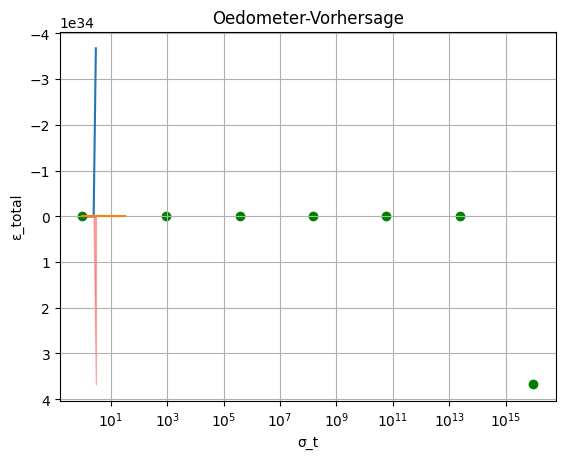

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import simpson

def simulate_oedometer_pinn(pinn, Oedometer, LabelTensor, normalize_data=False,
                             denormalize_delta_sigma=None, scaler=None,
                             start_val=10.00, e_0=1.00, C_c=0.005, delta_epsilon=0.0005,
                             max_n=20, rand_epsilon=False, plot_ln_sigma=False):
    """
    Führt eine Oedometer-Simulation mit einem PINN-Modell durch.
    
    Args:
        pinn: Das trainierte PINN-Modell.
        Oedometer: Oedometer-Klasse zur Spannungs-Dehnungs-Berechnung.
        LabelTensor: Funktion zum Erstellen eines beschrifteten Eingabe-Tensors.
        normalize_data (bool): Ob Daten normalisiert eingegeben werden.
        denormalize_delta_sigma (callable): Falls normalize_data=True, Funktion zur Rücktransformation.
        scaler: Skaler, der zur Denormalisierung verwendet wird.
        start_val (float): Startwert für sigma_t.
        e_0, C_c, delta_epsilon (float): Oedometer-Parameter.
        max_n (int): Anzahl der Iterationen.
        rand_epsilon (bool): Zufälliges epsilon oder nicht.
        plot_ln_sigma (bool): Falls True, wird die X-Achse als ln(σ_t) geplottet.
    """

    # Initiale Eingabe ins Oedometer-Modell
    input_oedo = {
        'e_0': e_0,
        'C_c': C_c,
        'delta_epsilon': delta_epsilon,
        'sigma_t': start_val,
        'max_n': max_n,
        'rand_epsilon': rand_epsilon
    }
    X = Oedometer(**input_oedo)

    # Initialisierung
    output_oedo = {
        'sigma_t': np.array([X.sigma_t[0]], dtype=np.float32),
        'delta_epsilon': np.array([X.delta_epsilon[0]], dtype=np.float32),
        'total_epsilon': np.array([0], dtype=np.float32),
        'delta_sigma': np.empty(0, dtype=np.float32),
        'e_s': np.array([X.e_s[0]], dtype=np.float32),
    }

    # Erste Eingabe
    input_data = LabelTensor(
        torch.tensor(np.column_stack((output_oedo['sigma_t'],)), dtype=torch.float),
        ['sigma_t']
    )

    for i in range(max_n):
        # Vorhersage
        if normalize_data and denormalize_delta_sigma is not None:
            delta_sigma_pred = denormalize_delta_sigma(pinn(input_data).detach().numpy(), scaler)
        else:
            delta_sigma_pred = pinn(input_data).detach().numpy()

        # Werte updaten
        output_oedo['delta_sigma'] = np.append(output_oedo['delta_sigma'], delta_sigma_pred[0])
        new_sigma = output_oedo['sigma_t'][i] + delta_sigma_pred[0]
        output_oedo['sigma_t'] = np.append(output_oedo['sigma_t'], new_sigma)

        new_epsilon = output_oedo['total_epsilon'][i] + output_oedo['delta_epsilon'][0]
        output_oedo['total_epsilon'] = np.append(output_oedo['total_epsilon'], new_epsilon)
        # Nächster Input
        input_data = LabelTensor(
            torch.tensor(np.column_stack((output_oedo['sigma_t'][i + 1],)), dtype=torch.float),
            ['sigma_t']
        )

        # e_s Update
        e_s_input = input_oedo.copy()
        e_s_input['sigma_t'] = new_sigma
        e_s_input['max_n'] = 1
        X_next = Oedometer(**e_s_input)
        output_oedo['e_s'] = np.append(output_oedo['e_s'], X_next.e_s[0])
    
    # Plotten 
    if plot_ln_sigma:
        sigma_t_true = np.array(X.sigma_t, dtype=np.float32)
        sigma_t_pred = np.array(output_oedo['sigma_t'][:-1], dtype=np.float32)

        es_true = np.array(X.e_s, dtype=np.float32)
        es_pred = np.array(output_oedo['e_s'][:-1], dtype=np.float32)
        
        es_sigma_true = np.array(X.e_s, dtype=np.float32) * sigma_t_true
        es_sigma_pred = np.array(output_oedo['e_s'][:-1], dtype=np.float32) * sigma_t_pred
  
        # Sigma - Epsilon
        plt.plot(sigma_t_true, es_sigma_true-es_sigma_pred)
        # Sigma - E_s * Sigma
        plt.plot(sigma_t_true, es_sigma_true)
        plt.scatter(sigma_t_pred, es_sigma_pred).set_color("green")
        plt.xscale('log')
        plt.xlabel("σ_t")
        # Fehlerflächen berechnen
        abs_error = np.abs(es_sigma_true - es_sigma_pred)
        area_l1 = simpson(abs_error, x=sigma_t_true)
          
    print(sigma_t_true)
    print(sigma_t_pred)
    plt.fill_between(sigma_t_true, es_sigma_true, es_sigma_pred, color='red', alpha=0.3, label='Fehlerfläche (|Δ|)')
    # plt.plot(mn  np.array(X.sigma_t, dtype=np.float32), np.array(X.total_epsilon, dtype=np.float32))
    plt.gca().invert_yaxis()
    plt.ylabel("ε_total")
    plt.title("Oedometer-Vorhersage")
    plt.grid(True)
    plt.show()

    
    return output_oedo

result = simulate_oedometer_pinn(
    pinn=pinn,
    start_val=1,
    Oedometer=Oedometer,
    LabelTensor=LabelTensor,
    normalize_data=False,
    denormalize_delta_sigma=None,
    scaler=None,
    plot_ln_sigma=True
)

# Testwerte (2 Input-Wert) $\Delta\epsilon=0,0005$

In [15]:
new_data = extract_excel(file_path="files/oedometer/oedo_trainingsdata_compare2.xlsx", sheet_name="Res", selected_columns=[1, 2, 3, 5], row_start_range=0)

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((new_data['sigma_t'])), dtype=torch.float
), ['sigma_t'])

display_data_loss_table(data_dict=new_data, delta_sigma_pred=pinn(input_data).detach().numpy(), max_i=20)
plot_prediction_vs_true_solution(pinn=pinn, data_dict=new_data, graph_folder=graph_folder, img_visual_prediction_vs_truesolution=img_visual_prediction_vs_truesolution_comp1, 
                                     img_extensions=img_extensions, y_axis='total_epsilon', max_i=20, plot_type="scatter")

{'sigma_t': array([1500,    0,    0,    0,    0,    0,    0,    0,    0,  854,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0]), 'total_epsilon': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'delta_epsilon': array([0.0005, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0005, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    ]), 'delta_sigma': array([300. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
       170.8,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ])}


ValueError: Number of dof (1) does not match tensor shape (20)

# Testwerte (2 Input-Wert) $\Delta\epsilon=0,001$

In [ ]:
new_data = extract_excel(file_path="files/oedometer/oedo_trainingsdata_compare3.xlsx", sheet_name="Res", selected_columns=[1, 2, 3, 5], row_start_range=0)

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((new_data['sigma_t'], new_data['delta_epsilon'])), dtype=torch.float
), ['sigma_t', 'delta_epsilon'])

display_data_loss_table(data_dict=new_data, delta_sigma_pred=pinn(input_data).detach().numpy(), max_i=20)
plot_prediction_vs_true_solution(pinn=pinn, data_dict=new_data, graph_folder=graph_folder, img_visual_prediction_vs_truesolution=img_visual_prediction_vs_truesolution_comp2, 
                                     img_extensions=img_extensions, y_axis='total_epsilon', max_i=20, plot_type="scatter")

Gemäß statischem Trainingswert für $\Delta\epsilon$ wurde keine korrekte Prognose vorgenommen.